# Building predictive models classifier partition by cases no dates

## Generic library methods

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

SEED = 17


def get_model_prediction(model, X_test):
    return model.predict(X_test)


def evaluate_model(model, X_test, y_test, y_predicted, model_name):
    merged_df = matrixes_to_dataframe(X_test, y_test)
    df_predicted = pd.DataFrame({ 'Label' : y_predicted, 'Index' : merged_df.index} )
    df_results = pd.DataFrame({ 'Label' : merged_df.Label, 'Index' : merged_df.index} )
    print_model_metrics(model, X_test, y_test, y_predicted, model_name)
    compare_prediction_visual(df_predicted , df_results, model_name)


def matrixes_to_dataframe(X_test, y_test):
    y_test_df = pd.DataFrame(y_test)
    y_test_df.columns = ['Label']
    X_test_df = pd.DataFrame(X_test)
    X_test_df.columns = ['Yesterday_Open', 'Yesterday_Close', 'Yesterday_Volume',
       'Yesterday_Low', 'Yesterday_High', 'Open', 'High', 'Low', 'Close',
       'Volume', 'OpenInt', 'Average_High_Low', 'Average_Day',
       'Diff_Close_Open', 'Diff_Today_Open', 'Diff_Today_Close',
       'Diff_Today_High', 'Diff_Today_Low', 'Month', 'Year', 'Day',
       'Yesterday_Month', 'Yesterday_Year', 'Yesterday_Day']
    df = pd.concat([X_test_df, y_test_df], axis=1, sort=False)
    return df

    
def compare_prediction_visual(df_predicted, df_real, model_name='Unknown model'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, sharex=True, facecolor='w', edgecolor='k', dpi=80)
    title = model_name + ' ' +  'classification results'
    df_predicted.plot(kind='scatter', x='Index',y='Label', ax=axs[0], title='Prediction results')
    df_real.plot(kind='scatter', x='Index',y='Label', ax=axs[1] ,title='Real classification results')
    save_plt_report(model_name)
    
    
def print_model_metrics(model, X_test, y_test, y_predicted, model_name='Unknown model'):
    print ('Metrics for model: {}'.format(model_name))
    warnings.filterwarnings('ignore')
    result = accuracy_score(y_test, y_predicted)
    print ('\tAccuracy: {0:.3f}'.format(result))
    print ('\tPrecision: {0:.3f}'.format(precision_score(y_test, y_predicted)))
    print ('\tRecall: {0:.3f}'.format(recall_score(y_test, y_predicted)))
    print ('\tPredicts {0:.3f}% time the stock price goes down'.format(result*100))
    cm = confusion_matrix(y_test, y_predicted)
    print( '\tConfusion matrix:')
    print(cm)
    
    title ="{}: Confusion matrix".format(model_name)
    file = '{}_confision_matrix.png'.format(model_name)
    disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=["Don't increase", "Increase"],
                             cmap=plt.cm.Blues, normalize=None, values_format="3.0f")
    disp.ax_.set_title(title)
    save_plt_report(file)
    plt.show()


def save_plt_report(file):
    visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'classifier-balanced', file)
    plt.savefig(visualization_path);

def describe_arrays(y, array_name):
    ## results descriptions 
    print ('')
    print ('')
    print ('mean amount of increases in {0} : {1:.3f}'.format(array_name, np.mean(y)))
    print ('total amount of increases in {0} : {1}'.format(array_name, np.sum(y)))
    print ('total amount of registers in {0} : {1}'.format(array_name, y.size))
    print ('total amount of decresses in {0} : {1}'.format(array_name, y.size - np.sum(y)))
    

def split_train_test_dataset(dataset):
    clean_dataset, result_df = generate_train_test_datasets(dataset)
    X  = clean_dataset.values.astype('float')
    y = result_df['Label'].ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=SEED)
    return X_train, X_test, y_train, y_test


def generate_train_test_datasets(dataset):
    result_df = pd.DataFrame()
    result_df['Label'] = dataset.Label
    result_df['Index'] = dataset.index
    result_df['Date'] =  dataset.Date
    clean_dataset = dataset.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    print(clean_dataset.columns)
    return clean_dataset, result_df
    

def load_dataset(subfolder='', file='aapl.us.txt', data_type='raw', index_column=0):
    data_path = os.path.join(os.path.pardir, 'data', data_type, subfolder, file)
    print('Opening file ', data_path)
    df = pd.read_csv(data_path, index_col=index_column)
    print('%d missing values found' % df.isnull().sum().sum())
    return df




In [2]:
dataset = load_dataset(file='dataset_feature_vector.csv', data_type='processed') 
X_train, X_test, y_train, y_test = split_train_test_dataset(dataset )
describe_arrays(y_train, "y_train")
describe_arrays(y_test, "y_test")

Opening file  ../data/processed/dataset_feature_vector.csv
0 missing values found
Index(['Yesterday_Open', 'Yesterday_Close', 'Yesterday_Volume',
       'Yesterday_Low', 'Yesterday_High', 'Open', 'High', 'Low', 'Close',
       'Volume', 'OpenInt', 'Average_High_Low', 'Average_Day',
       'Diff_Close_Open', 'Diff_Today_Open', 'Diff_Today_Close',
       'Diff_Today_High', 'Diff_Today_Low', 'Month', 'Year', 'Day',
       'Yesterday_Month', 'Yesterday_Year', 'Yesterday_Day'],
      dtype='object')


mean amount of increases in y_train : 0.490
total amount of increases in y_train : 3074
total amount of registers in y_train : 6271
total amount of decresses in y_train : 3197


mean amount of increases in y_test : 0.507
total amount of increases in y_test : 1061
total amount of registers in y_test : 2091
total amount of decresses in y_test : 1030


## Generate models

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

def generate_simple_logistic_model(X_train, y_train):
    model = LogisticRegression(random_state=0, solver='liblinear')
    model.fit(X_train,y_train)
    return model
    

def generate_dummy_model(X_train, y_train):
    model = DummyClassifier(strategy='most_frequent', random_state=0)
    model.fit(X_train, y_train)
    return model

Metrics for model: Linear model
	Accuracy: 0.493
	Precision: 0.000
	Recall: 0.000
	Predicts 49.259% time the stock price goes down
	Confusion matrix:
[[1030    0]
 [1061    0]]


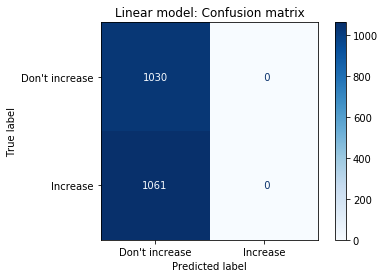

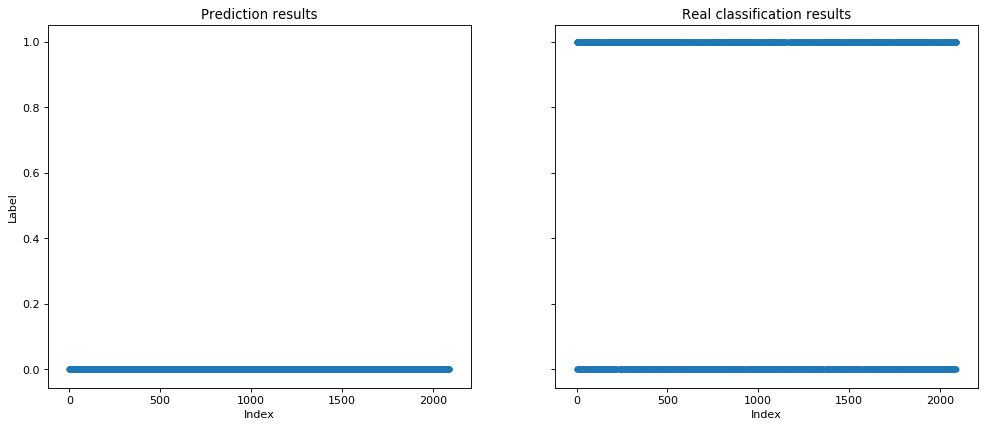

In [4]:
linear_model = generate_dummy_model(X_train, y_train)
y_predicted = get_model_prediction(linear_model, X_test)
evaluate_model(linear_model, X_test, y_test, y_predicted, "Linear model")

Metrics for model: Logistic model
	Accuracy: 0.531
	Precision: 0.529
	Recall: 0.687
	Predicts 53.085% time the stock price goes down
	Confusion matrix:
[[381 649]
 [332 729]]


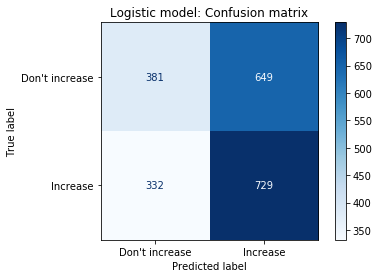

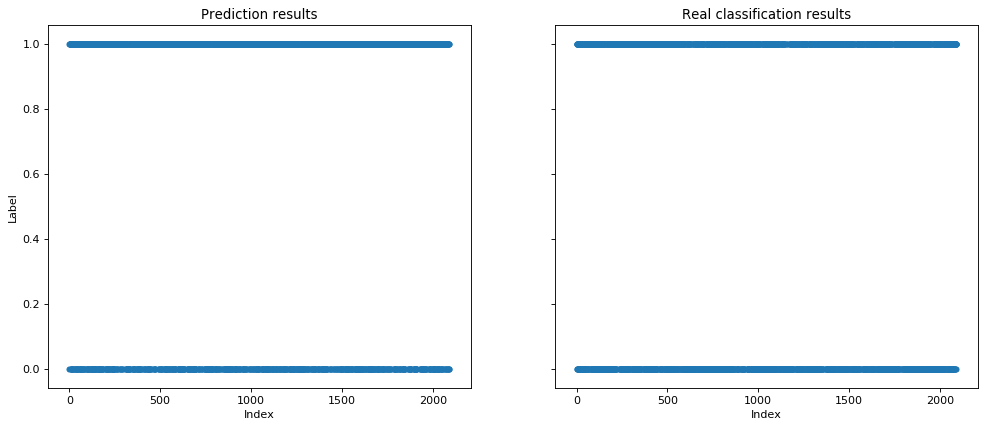

In [5]:
logistic_model = generate_simple_logistic_model(X_train, y_train)
y_predicted = get_model_prediction(logistic_model, X_test)
evaluate_model(logistic_model, X_test, y_test, y_predicted, "Logistic model")

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

def generate_GS_logistic_model(X_train, y_train):
    logistic_model = generate_simple_logistic_model(X_train, y_train)
    parameters = {'C':[1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty' : ['l1','l2'],'class_weight' : ['balanced',None], 'solver' : ['liblinear','saga'], 'max_iter' : [100,1000,10000]}
    model = GridSearchCV(logistic_model, param_grid=parameters, cv=3)
    with ignore_warnings(category=ConvergenceWarning):
        model.fit(X_train, y_train)
    print ('Best parameters for logistic model grid {}'.format(model.best_params_))
    print ('Best score : {0:.2f}'.format(model.best_score_))
    return model

Best parameters for logistic model grid {'C': 100.0, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best score : 0.87
Metrics for model: Logistic model grid search
	Accuracy: 0.858
	Precision: 0.861
	Recall: 0.861
	Predicts 85.844% time the stock price goes down
	Confusion matrix:
[[882 148]
 [148 913]]


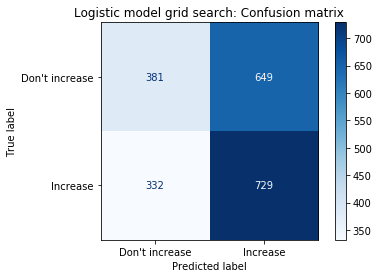

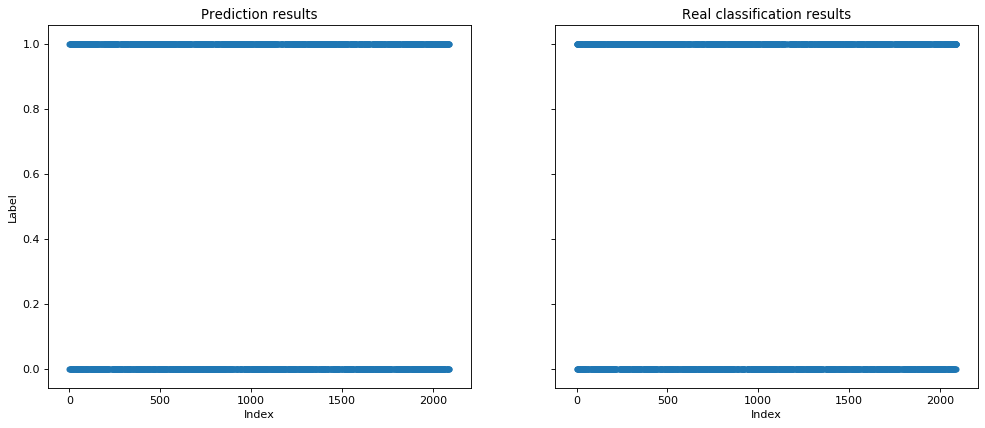

In [7]:
logistic_GS_model = generate_GS_logistic_model(X_train, y_train)
y_predicted = get_model_prediction(logistic_GS_model, X_test)
evaluate_model(logistic_model, X_test, y_test, y_predicted, "Logistic model grid search")

## Feature standarization

In [8]:
def generate_FS_GS_logistic_model(X_train, y_train):
    logistic_model = generate_simple_logistic_model(X_train, y_train)
    parameters = {'C':[1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty' : ['l1','l2'],'class_weight' : ['balanced',None], 'solver' : ['liblinear','saga'], 'max_iter' : [100,1000,10000]}
    model = GridSearchCV(logistic_model, param_grid=parameters, cv=3)

    with ignore_warnings(category=ConvergenceWarning):
        model.fit(X_train, y_train)
    
    print ('Best parameters for logistic model grid {}'.format(model.best_params_))
    print ('Best score : {0:.2f}'.format(model.best_score_))
    return model


Best parameters for logistic model grid {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score : 0.87
Metrics for model: Logistic model with feature standarization and grid search
	Accuracy: 0.862
	Precision: 0.861
	Recall: 0.867
	Predicts 86.179% time the stock price goes down
	Confusion matrix:
[[882 148]
 [141 920]]


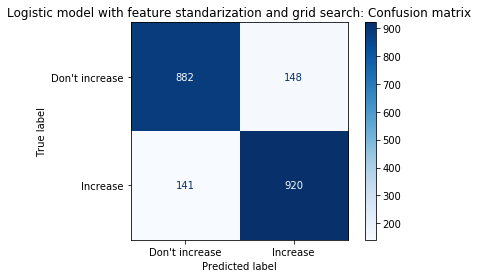

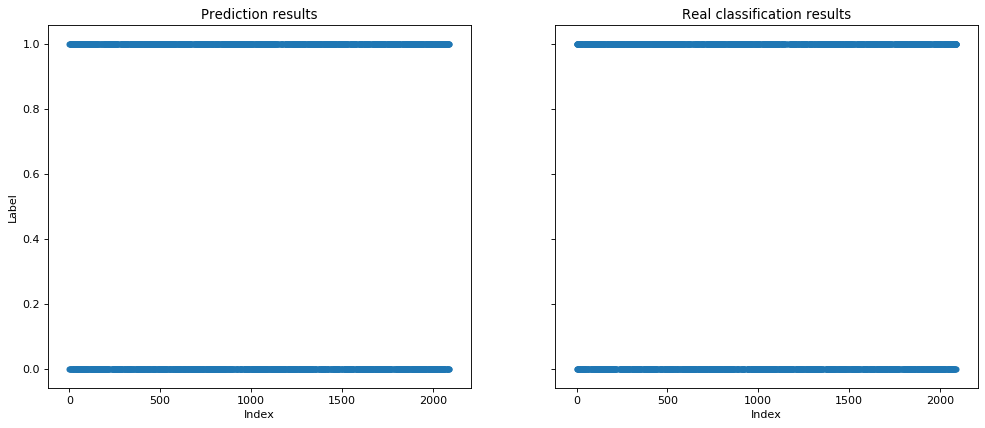

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logistic_FS_GS_model = generate_FS_GS_logistic_model(X_train_scaled, y_train)
y_predicted = get_model_prediction(logistic_FS_GS_model, X_test_scaled)
evaluate_model(logistic_FS_GS_model, X_test_scaled, y_test, y_predicted, "Logistic model with feature standarization and grid search")

## Random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
def generate_random_forest_model(X_train, y_train):
    parameters = {
        'n_estimators':[50, 100, 200,1000], 
        'min_samples_leaf':[1, 5,10,50],
        'max_features' : ('auto','sqrt','log2'),
    }
    rf = RandomForestClassifier(random_state=0, oob_score=True)
    model = GridSearchCV(rf, parameters, cv=5)
    with ignore_warnings(category=ConvergenceWarning):
        model.fit(X_train, y_train)
        
    print ('Best parameters for random forest model grid {}'.format(model.best_params_))
    print ('Best score : {0:.2f}'.format(model.best_score_))
    return model 

Best parameters for random forest model grid {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 50}
Best score : 0.87
Metrics for model: Random Forest with grid search
	Accuracy: 0.863
	Precision: 0.869
	Recall: 0.859
	Predicts 86.275% time the stock price goes down
	Confusion matrix:
[[893 137]
 [150 911]]


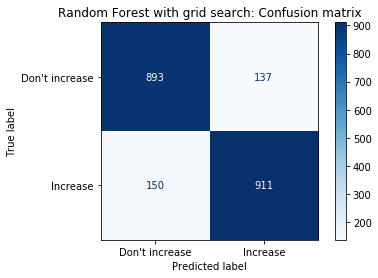

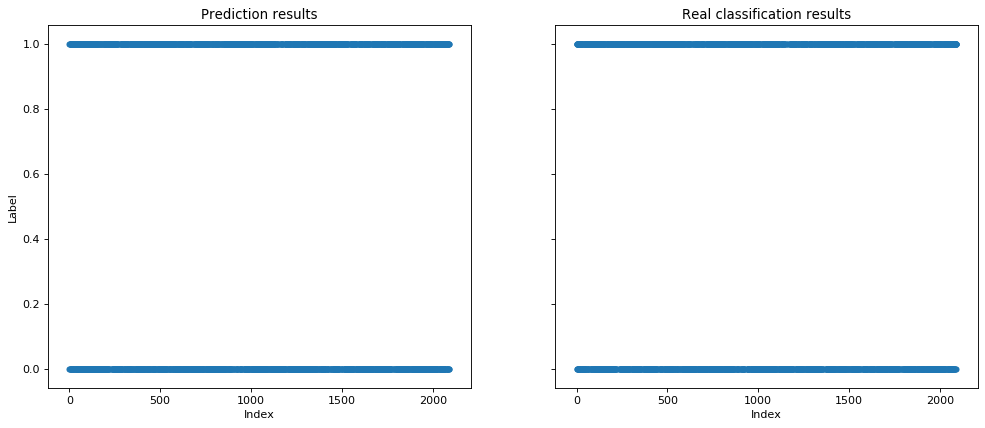

In [11]:
random_forest_GS_model = generate_random_forest_model(X_train, y_train)
y_predicted = get_model_prediction(random_forest_GS_model, X_test)
evaluate_model(random_forest_GS_model, X_test, y_test, y_predicted, "Random Forest with grid search")